## DataSchool - Machine Learning with Text and Python:  

### Week 6 Self Imposed Homework

I am going to use the Kaggle competition that inspired me to sign up for this course.  Using what I have learned in the Machine Learning with Text course, I will attempt to beat the scores on the leader board.

The Kaggle competition is:

![SA Image](sa_emotions_picture.png) 

### [Sentiment Analysis: Emotion in Text.](https://www.kaggle.com/c/sa-emotions)

*Identify emotion in text using sentiment analysis.*

In [196]:
import numpy as np
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from stemming.porter2 import stem
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline, make_union
from sentiment_analysis.transformers import RemoveEllipseTransformer, RemoveHtmlEncodedTransformer, RemoveNumbersTransformer, RemoveSpecialCharactersTransformer, RemoveUsernameTransformer, RemoveUrlsTransformer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.base import TransformerMixin
import re
import nltk.stem
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from nltk.sentiment.util import mark_negation

In [157]:
# allow plots to appear in the notebook
%matplotlib inline

In [75]:
# read the training data
training_data = pd.read_csv('../data/kaggle/sa-emotions/train_data.csv')

In [76]:
# look at the shape of the data.  Kaggle stated that the training data consisted of 30000 rows and 2 columns
training_data.shape

(30000, 2)

In [77]:
training_data.dtypes

sentiment    object
content      object
dtype: object

In [78]:
# update the pd option to increase the column width so we can see more of the text
pd.set_option('max_colwidth',200)

In [79]:
# look at a small sample of the data by looking at every 1000th
training_data[::1000]

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1000,worry,@Sageey My public talk in July got canceled and I don't know why.
2000,sadness,Epic ocd moment? I deleted my sims file that i spent hours building just because i set his favorite food wrong
3000,worry,[BBC] Malaria parasites becoming resistant to drugs http://trunc.it/9yn5 ~ this is really not good as Malaria affects so many people
4000,neutral,"my to do list is bananas, before i leave for Europe BOOOO"
5000,sadness,darn it. I did it again.! keep forgetting that darn &quot;D&quot; for DM's.....
6000,neutral,@chelsea_playboy R.I.P curls
7000,neutral,@Jeanise I was going to say let's go to lunch...
8000,sadness,argh! why why why
9000,worry,@vronmcintyre I want an espresso machine


In [80]:
# check for null or NaN values in the columns
training_data.isnull().sum()

sentiment    0
content      0
dtype: int64

In [81]:
# look at the sentiment distribution
training_data.sentiment.value_counts()

worry         7433
neutral       6340
sadness       4828
happiness     2986
love          2068
surprise      1613
hate          1187
fun           1088
relief        1021
empty          659
enthusiasm     522
boredom        157
anger           98
Name: sentiment, dtype: int64

In [82]:
# look at the percent distribution of sentiment
training_data.sentiment.value_counts()/training_data.sentiment.value_counts().sum()

worry         0.247767
neutral       0.211333
sadness       0.160933
happiness     0.099533
love          0.068933
surprise      0.053767
hate          0.039567
fun           0.036267
relief        0.034033
empty         0.021967
enthusiasm    0.017400
boredom       0.005233
anger         0.003267
Name: sentiment, dtype: float64

> Some of sentiments have a very low percent of the total count.  It is expected that it will be difficult to accurately predict anger and boredom.

In [83]:
# encode the sentiment outcomes as a number using the LabelEncoder
# would like to create a column, e.g. sentiment_num, which is a numeric representation of the sentiment.
# this will have to also be applied to any test data.
label_encoder = LabelEncoder()

# fit the label encoder with the unique set of sentiments in the training data.
label_encoder.fit(training_data.sentiment.unique())

LabelEncoder()

In [84]:
# print out what classes were discovered
list(label_encoder.classes_)

['anger',
 'boredom',
 'empty',
 'enthusiasm',
 'fun',
 'happiness',
 'hate',
 'love',
 'neutral',
 'relief',
 'sadness',
 'surprise',
 'worry']

In [85]:
# planning ahead, create a function to create features in a data set that we will have to create in 
# both the training and testing data
def make_features(df, sentiment_num_encoder):
    training_data['sentiment_num'] = training_data.sentiment.apply(lambda x: label_encoder.transform([x])[0])

In [86]:
make_features(training_data, sentiment_num_encoder=label_encoder)
training_data[::1000]

,sentiment,content,sentiment_num
0,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,2
1000,worry,@Sageey My public talk in July got canceled and I don't know why.,12
2000,sadness,Epic ocd moment? I deleted my sims file that i spent hours building just because i set his favorite food wrong,10
3000,worry,[BBC] Malaria parasites becoming resistant to drugs http://trunc.it/9yn5 ~ this is really not good as Malaria affects so many people,12
4000,neutral,"my to do list is bananas, before i leave for Europe BOOOO",8
5000,sadness,darn it. I did it again.! keep forgetting that darn &quot;D&quot; for DM's.....,10
6000,neutral,@chelsea_playboy R.I.P curls,8
7000,neutral,@Jeanise I was going to say let's go to lunch...,8
8000,sadness,argh! why why why,10
9000,worry,@vronmcintyre I want an espresso machine,12


## Base Line DataFrame

The dataset is now minimally ready to investigate further.

The next steps are Data Preprocessing to cleanse the data, and Feature Engineering

### Data Preprocessing

Look at the data and see if we can/should clean the content before we attempt to engineer features and

create tokens.

For example, there is a very good chance that user names like '@Crazy_Cindy' has no relationship to emotion and is likely a good candidate to remove from the content before vectorization.

To verify this - we will create a baseline and compare against the base.  For the baseline a generic CountVectorizer will be used with a MultinomialNB model.


In [87]:
# baseline pipeline.
baseline_pipeline = make_pipeline(CountVectorizer(), MultinomialNB())

In [88]:
# Define the X and y variables
X = training_data.content
y = training_data.sentiment_num

In [89]:
# cross-validate the entire pipeline
baseline_accuracy = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='accuracy').mean()
print(baseline_accuracy)

0.285673524552


In [90]:
# look at the baseline number of features
vect = CountVectorizer()
vect.fit(X)
baseline_number_of_features = len(vect.get_feature_names())
print(baseline_number_of_features)

38892


### Preprocessing Transformers.

This section will contain a number of transformers that will be applied as part of a preprocessing pipeline.  Each custom transformer inherits from TransformerMixin.

In [91]:
def test_transformer(transformer, data):
    """
    Assumes:
    1) training_data variable is available
    2) baseline_pipeline variable is available
    3) baseline_number_of_features variable is available
    4) baseline_accuracy variable is available
    """
    new_content = transformer.transform(data)
    # Define new X and y variables
    X = new_content
    y = training_data.sentiment_num
    # cross-validate the entire pipeline
    cv_score = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='accuracy').mean()
    vect = CountVectorizer()
    vect.fit(X)
    num_feats = len(vect.get_feature_names())
    diff = num_feats - baseline_number_of_features
    accuracy_diff = cv_score - baseline_accuracy
    print("Accuracy: {0} Accuracy Diff: {1}\nTransformed: {2} Baseline: {3} Feature Diff: {4}".format(cv_score, accuracy_diff, num_feats, baseline_number_of_features, diff))


> #### A transformer to remove username 

In [92]:
class RemoveUsernameTransformer(TransformerMixin):

    @staticmethod
    def _preprocess_data(data_series):
        """
        inspired from:
        https://raw.githubusercontent.com/youngsoul/ml-twitter-sentiment-analysis/develop/cleanup.py
        :param data_series:
        :return:
        """

        # remove user name
        regex = re.compile(r"@[^\s]+[\s]?")
        data_series.replace(regex, "", inplace=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """

        :param X: Series, aka column of data.
        :return:
        """
        RemoveUsernameTransformer._preprocess_data(X)
        return X


In [93]:
# Remove the user name, save the series in a new series and see if it helped the model
ru = RemoveUsernameTransformer()
test_transformer(ru, training_data.content.copy())


Accuracy: 0.2907763836290118 Accuracy Diff: 0.005102859076697719
Transformed: 26729 Baseline: 38892 Feature Diff: -12163


> Since the accuracy is a slight improvement, 0.285 vs 0.290, we will keep the remove username transform.

> Remove ellipse transformer

In [94]:
class RemoveEllipseTransformer(TransformerMixin):

    @staticmethod
    def _preprocess_data(data_series):
        """
        inspired from:
        https://raw.githubusercontent.com/youngsoul/ml-twitter-sentiment-analysis/develop/cleanup.py
        :param data_series:
        :return:
        """
        # remove ..., ...., ..... with space
        for remove in map(lambda r: re.compile(r), ["\.\.\.\.\.", "\.\.\.\.", "\.\.\."]):
            data_series.replace(remove, " ", inplace=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """

        :param X: Series, aka column of data.
        :return:
        """
        RemoveEllipseTransformer._preprocess_data(X)
        return X


In [95]:
# Remove the ellipse, save the series in a new series and see if it helped the model
ru = RemoveEllipseTransformer()
test_transformer(ru, training_data.content.copy())


Accuracy: 0.2856735245523141 Accuracy Diff: 0.0
Transformed: 38892 Baseline: 38892 Feature Diff: 0


> Since there is no improvement, and the feature count is the same,  It is assumed that CountVectorizer must be removing them as well.  So we will not use this transformer

In [96]:
class RemoveNumbersTransformer(TransformerMixin):

    @staticmethod
    def _preprocess_data(data_series):
        """
        inspired from:
        https://raw.githubusercontent.com/youngsoul/ml-twitter-sentiment-analysis/develop/cleanup.py
        :param data_series:
        :return:
        """

        # remove numbers
        regex = re.compile(r"\s?[0-9]+\.?[0-9]*")
        data_series.replace(regex, "", inplace=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """

        :param X: Series, aka column of data.
        :return:
        """
        RemoveNumbersTransformer._preprocess_data(X)
        return X


In [97]:
# Remove the user name, save the series in a new series and see if it helped the model
rt = RemoveNumbersTransformer()
test_transformer(rt, training_data.content.copy())

Accuracy: 0.2862739473545161 Accuracy Diff: 0.0006004228022020164
Transformed: 37954 Baseline: 38892 Feature Diff: -938


> Slight improvement, keep RemoveNumbersTransformer

In [98]:
class RemoveSpecialCharactersTransformer(TransformerMixin):

    @staticmethod
    def _preprocess_data(data_series):
        """
        inspired from:
        https://raw.githubusercontent.com/youngsoul/ml-twitter-sentiment-analysis/develop/cleanup.py
        :param data_series:
        :return:
        """

        # remove special characters
        for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                               "@", "%", "^", "*", "(", ")", "{", "}",
                                                               "[", "]", "|", "/", "\\", ">", "<", "-",
                                                               "!", "?", ".", "'",
                                                               "--", "---", "#"]):
            data_series.replace(remove, "", inplace=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """

        :param X: Series, aka column of data.
        :return:
        """
        RemoveSpecialCharactersTransformer._preprocess_data(X)
        return X


In [99]:
rt = RemoveSpecialCharactersTransformer()
test_transformer(rt, training_data.content.copy())

Accuracy: 0.2804398102040787 Accuracy Diff: -0.005233714348235385
Transformed: 43034 Baseline: 38892 Feature Diff: 4142


> This transformer resulted in slightly worse performance, so we will not use it.

In [100]:
class RemoveHtmlEncodedTransformer(TransformerMixin):

    @staticmethod
    def _preprocess_data(data_series):
        """
        inspired from:
        https://raw.githubusercontent.com/youngsoul/ml-twitter-sentiment-analysis/develop/cleanup.py
        :param data_series:
        :return:
        """

        # html encoded characters
        for remove in map(lambda r: re.compile(r), ["&lt;", "&gt;", "&quot;", "&amp;", "w/o", "w/"]):
            data_series.replace(remove, "", inplace=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """

        :param X: Series, aka column of data.
        :return:
        """
        RemoveHtmlEncodedTransformer._preprocess_data(X)
        return X


In [101]:
rt = RemoveHtmlEncodedTransformer()
test_transformer(rt, training_data.content.copy())

Accuracy: 0.2854400243132305 Accuracy Diff: -0.00023350023908358386
Transformed: 38954 Baseline: 38892 Feature Diff: 62


> Slighty worse performance so we will not use it

In [102]:
class RemoveUrlsTransformer(TransformerMixin):

    @staticmethod
    def _preprocess_data(data_series):
        """
        inspired from:
        https://raw.githubusercontent.com/youngsoul/ml-twitter-sentiment-analysis/develop/cleanup.py
        :param data_series:
        :return:
        """

        # remove urls
        regex = re.compile(r"http.?://[^\s]+[\s]?")
        data_series.replace(regex, "", inplace=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """

        :param X: Series, aka column of data.
        :return:
        """
        RemoveUrlsTransformer._preprocess_data(X)
        return X


In [103]:
rt = RemoveUrlsTransformer()
test_transformer(rt, training_data.content.copy())

Accuracy: 0.28373921215917475 Accuracy Diff: -0.001934312393139348
Transformed: 37666 Baseline: 38892 Feature Diff: -1226


> Slightly worse so we will not use it.

The only Transformers we will use are:
> RemoveNumbersTransformer, RemoveUsernameTransformer

In [104]:
# Create a pipeline with the transformers we are keeping, and see the overall improvement.
preprocessor_pipeline = make_pipeline(RemoveNumbersTransformer(), RemoveUsernameTransformer())
test_transformer(preprocessor_pipeline, training_data.content.copy())

Accuracy: 0.29211011817381577 Accuracy Diff: 0.006436593621501674
Transformed: 26085 Baseline: 38892 Feature Diff: -12807


## Add Stemming to CountVectorizer to see if this helps

Stemming can be added via NLTK or the stemming python package.

In [105]:
# https://github.com/AishwaryaRK/scikit-learn/commit/cb8afbc11fbe34c1378665040b605fb16784f77c
class StemmedCountVectorizer(CountVectorizer):
    
    def __init__(self, stemmer=None, input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None,
                 lowercase=True, preprocessor=None, tokenizer=None,
                 stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
                 ngram_range=(1, 1), analyzer='word',
                 max_df=1.0, min_df=1, max_features=None,
                 vocabulary=None, binary=False, dtype=np.int64):
        super(StemmedCountVectorizer, self).__init__(
            input=input, encoding=encoding, decode_error=decode_error,
            strip_accents=strip_accents, lowercase=lowercase,
            preprocessor=preprocessor, tokenizer=tokenizer, analyzer=analyzer,
            stop_words=stop_words, token_pattern=token_pattern,
            ngram_range=ngram_range, max_df=max_df, min_df=min_df,
            max_features=max_features, vocabulary=vocabulary, binary=binary,
            dtype=dtype)        
        self.stemmer = stemmer
            
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        if self.stemmer == None:
            return analyzer
        
        return lambda doc: ([self.stemmer.stem(w) for w in analyzer(doc)])
    

In [106]:
stemmer = nltk.stem.SnowballStemmer('english')
stemmed_count_vectorizer = StemmedCountVectorizer(stemmer=stemmer)

# baseline pipeline.
stem_pipeline = make_pipeline(stemmed_count_vectorizer, MultinomialNB())
# Define the X and y variables
X = training_data.content
y = training_data.sentiment_num
# cross-validate the entire pipeline
baseline_accuracy = cross_val_score(stem_pipeline, X, y, cv=5, scoring='accuracy').mean()
print(baseline_accuracy)

0.286609620222


Putting the preprocessing pipeline and the Stemmed CountVectorizer into a single pipeline

In [107]:
# Create a pipeline with the transformers we are keeping, and see the overall improvement.
# re-establish X and y
X = training_data.content
y = training_data.sentiment_num

# create a pipeline of all of the steps we are currently keeping
preprocessor_stem_pipeline = make_pipeline(RemoveNumbersTransformer(), RemoveUsernameTransformer(), StemmedCountVectorizer(stemmer=stemmer), MultinomialNB())

# use cross validation on the pipeline to measure the accuracy.  Recall - we are using default parameters
# for CountVectorizor and NB.
preprocessor_stem_accuracy = cross_val_score(preprocessor_stem_pipeline, X, y, cv=5, scoring='accuracy').mean()
print(preprocessor_stem_accuracy)

0.296544703778


In [108]:
print("Base Accuracy: {0} PreProcess Stem Accuracy: {1} Diff: {2}".format(baseline_accuracy, preprocessor_stem_accuracy, (preprocessor_stem_accuracy - baseline_accuracy)))

Base Accuracy: 0.2866096202222253 PreProcess Stem Accuracy: 0.29654470377779213 Diff: 0.009935083555566826


## Tune CountVectorizer

Look at the different parameters for CountVectorizer and see if tuning those parameters help.  Also potentially look into TFIDF Vectorizer

First, run the preprocessor_pipeline on the entire training data set.

Second, create a model pipeline that will run through the CountVectorizer and the MultinomialNB model.


In [109]:

preprocessed_training_data = preprocessor_pipeline.transform(training_data)
# Define new X and y variables
X = preprocessed_training_data
y = training_data.sentiment_num

In [110]:
# pipeline steps are automatically assigned names by make_pipeline
stem_pipeline.named_steps.keys()

dict_keys(['stemmedcountvectorizer', 'multinomialnb'])

In [111]:
# create a grid of parameters to search (and specify the pipeline step along with the parameter)
param_grid = {}
param_grid['stemmedcountvectorizer__min_df'] = [2,3,4,5]
param_grid['stemmedcountvectorizer__max_df'] = [0.6,0.8]
param_grid['stemmedcountvectorizer__stop_words'] = ['english']
param_grid['stemmedcountvectorizer__ngram_range'] = [(1,1),(1,2),(1,3),(1,4)]
param_grid['multinomialnb__alpha'] = [0.5, 1]
param_grid

{'multinomialnb__alpha': [0.5, 1],
 'stemmedcountvectorizer__max_df': [0.6, 0.8],
 'stemmedcountvectorizer__min_df': [2, 3, 4, 5],
 'stemmedcountvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
 'stemmedcountvectorizer__stop_words': ['english']}

In [112]:
grid = GridSearchCV(stem_pipeline, param_grid, cv=5, scoring='accuracy')

In [113]:
# time the grid search
# %time grid.fit(X, y)

#CPU times: user 2h 47min 34s, sys: 42.8 s, total: 2h 48min 17s
#Wall time: 2h 49min 5s

> CPU times: user 2h 47min 34s, sys: 42.8 s, total: 2h 48min 17s

> Wall time: 2h 49min 5s

In [114]:
# print the single best score and parameters that produced that score
#print(grid.best_score_)
#print(grid.best_params_)

print("Best Score: 0.3015")
print("Best Params: {'multinomialnb__alpha': 1, 'stemmedcountvectorizer__max_df': 0.6, 'stemmedcountvectorizer__min_df': 3, 'stemmedcountvectorizer__ngram_range': (1, 3), 'stemmedcountvectorizer__stop_words': 'english'}")


Best Score: 0.3015
Best Params: {'multinomialnb__alpha': 1, 'stemmedcountvectorizer__max_df': 0.6, 'stemmedcountvectorizer__min_df': 3, 'stemmedcountvectorizer__ngram_range': (1, 3), 'stemmedcountvectorizer__stop_words': 'english'}


> 0.3015
{'multinomialnb alpha': 1, 'stemmedcountvectorizer max_df': 0.6, 'stemmedcountvectorizer min_df': 3, 'stemmedcountvectorizer ngram_range': (1, 3), 'stemmedcountvectorizer stop_words': 'english'}

### Stemmed CountVectorizer with Multinomial Naive Bayes Summary

  - Multinomial NB alpha = 1
  - stemmer = nltk.stem.SnowballStemmer('english')
  - CountVectorizer max_df = 0.6
  - CountVectorizer min_df = 3
  - CountVectorizer ngram_range = (1,3)
  - CountVectorizer stop_words = 'english'
  
The best score was 0.3015

### Stemmed TF-IDF Vectorizer with LogisticRegression

In a previous run, I did discover that the above combination was the best.  Lets try this combination to see if we can better the score.



In [115]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def __init__(self, stemmer=None, input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None, lowercase=True,
                 preprocessor=None, tokenizer=None, analyzer='word',
                 stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
                 ngram_range=(1, 1), max_df=1.0, min_df=1,
                 max_features=None, vocabulary=None, binary=False,
                 dtype=np.int64, norm='l2', use_idf=True, smooth_idf=True,
                 sublinear_tf=False):

        super(StemmedTfidfVectorizer, self).__init__(
            input=input, encoding=encoding, decode_error=decode_error,
            strip_accents=strip_accents, lowercase=lowercase,
            preprocessor=preprocessor, tokenizer=tokenizer, analyzer=analyzer,
            stop_words=stop_words, token_pattern=token_pattern,
            ngram_range=ngram_range, max_df=max_df, min_df=min_df,
            max_features=max_features, vocabulary=vocabulary, binary=binary,
            dtype=dtype, norm='l2', use_idf=True, smooth_idf=True,
                             sublinear_tf=False)
        self.stemmer = stemmer

    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([self.stemmer.stem(w) for w in analyzer(doc)])


In [116]:
# re- read the training data
training_data = pd.read_csv('../data/kaggle/sa-emotions/train_data.csv')

In [117]:
# encode the sentiment outcomes as a number using the LabelEncoder
# would like to create a column, e.g. sentiment_num, which is a numeric representation of the sentiment.
# this will have to also be applied to any test data.
label_encoder = LabelEncoder()

# fit the label encoder with the unique set of sentiments in the training data.
label_encoder.fit(training_data.sentiment.unique())
# planning ahead, create a function to create features in a data set that we will have to create in 
# both the training and testing data
def make_features(df, sentiment_num_encoder):
    training_data['sentiment_num'] = training_data.sentiment.apply(lambda x: label_encoder.transform([x])[0])
    
make_features(training_data, sentiment_num_encoder=label_encoder)
training_data[::1000]

,sentiment,content,sentiment_num
0,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,2
1000,worry,@Sageey My public talk in July got canceled and I don't know why.,12
2000,sadness,Epic ocd moment? I deleted my sims file that i spent hours building just because i set his favorite food wrong,10
3000,worry,[BBC] Malaria parasites becoming resistant to drugs http://trunc.it/9yn5 ~ this is really not good as Malaria affects so many people,12
4000,neutral,"my to do list is bananas, before i leave for Europe BOOOO",8
5000,sadness,darn it. I did it again.! keep forgetting that darn &quot;D&quot; for DM's.....,10
6000,neutral,@chelsea_playboy R.I.P curls,8
7000,neutral,@Jeanise I was going to say let's go to lunch...,8
8000,sadness,argh! why why why,10
9000,worry,@vronmcintyre I want an espresso machine,12


In [118]:
# Create a pipeline with the transformers we are keeping, and see the overall improvement.
preprocessor_pipeline = make_pipeline(RemoveNumbersTransformer(), RemoveUsernameTransformer())

# create stemmer
stemmer = nltk.stem.SnowballStemmer('english')
# 0.3145 stemmed_tfidf_vectorizer = StemmedTfidfVectorizer(stemmer=stemmer, min_df=5, max_df=0.8, ngram_range=(1,4), sublinear_tf=True,  stop_words='english')
stemmed_tfidf_vectorizer = StemmedTfidfVectorizer(stemmer=stemmer, min_df=5, max_df=0.8, ngram_range=(1,4), stop_words='english')

# baseline pipeline.
tfidf_stem_pipeline = make_pipeline(stemmed_tfidf_vectorizer, LogisticRegression(C=0.1))


In [119]:
preprocessed_training_data = preprocessor_pipeline.transform(training_data.content)
# Define new X and y variables
X = preprocessed_training_data
y = training_data.sentiment_num

In [120]:
print(X.shape)
print(y.shape)

(30000,)
(30000,)


In [121]:
X.head()

0    i know  i was listenin to bad habit earlier and i started freakin at his part =[
1                        Layin n bed with a headache  ughhhh...waitin on your call...
2                                                 Funeral ceremony...gloomy friday...
3                                                wants to hang out with friends SOON!
4             We want to trade with someone who has Houston tickets, but no one will.
Name: content, dtype: object

In [122]:
# create a grid of parameters to search (and specify the pipeline step along with the parameter)
param_grid = {}
param_grid['stemmedtfidfvectorizer__sublinear_tf'] = [False, True]
param_grid

{'stemmedtfidfvectorizer__sublinear_tf': [False, True]}

In [123]:
grid = GridSearchCV(tfidf_stem_pipeline, param_grid, cv=5, scoring='accuracy')

In [124]:
# time the grid search
# comment out because we do not want to run every time. %time grid.fit(X, y)

In [125]:
# print the single best score and parameters that produced that score
#print(grid.best_score_)
#print(grid.best_params_)

print("Best Score: 0.3153")
print("Best Params: {'stemmedtfidfvectorizer__sublinear_tf': True}")

Best Score: 0.3153
Best Params: {'stemmedtfidfvectorizer__sublinear_tf': True}


## Model Conclusion

It appears that a Stemmed TFIDFVectorizer, and LogisticRegression are so far the best combination.

Below is the summarized pipelines

In [126]:
# Create a pipeline with the transformers we are keeping, and see the overall improvement.
preprocessor_pipeline = make_pipeline(RemoveNumbersTransformer(), RemoveUsernameTransformer())

# create stemmer
stemmer = nltk.stem.SnowballStemmer('english')
stemmed_tfidf_vectorizer = StemmedTfidfVectorizer(stemmer=stemmer, min_df=5, max_df=0.8, ngram_range=(1,4), stop_words='english', sublinear_tf=True)

# baseline pipeline.
tfidf_stem_pipeline = make_pipeline(stemmed_tfidf_vectorizer, LogisticRegression(C=0.1))
preprocessed_training_data = preprocessor_pipeline.transform(training_data)
# Define new X and y variables
X = preprocessed_training_data.content
y = training_data.sentiment_num

## Summary 

The block below is a summary of all of the steps in one place for a simple review.  It was decided to go with LogisticRegression.

In [127]:
def mark_negation_sentence(sentence):
    """
    This function will take a sentence in, split it and call mark_negation, and 
    puts the string back together again.  
    
    Append _NEG suffix to words that appear in the scope between a negation
    and a punctuation mark.
    
    :param sentence an entire sentence
    :return sentence with the negation marked
    """
    return " ".join(mark_negation(sentence.split()))


In [128]:
# Now that we have an idea of what model we want to use, create a more traditional, train_test_split and
# look at things like the confusion matrix, etc

    
# read in the training data
training_data = pd.read_csv('../data/kaggle/sa-emotions/train_data.csv')

# encode the sentiment outcomes as a number using the LabelEncoder
# would like to create a column, e.g. sentiment_num, which is a numeric representation of the sentiment.
# this will have to also be applied to any test data.
label_encoder = LabelEncoder()

# fit the label encoder with the unique set of sentiments in the training data.
label_encoder.fit(training_data.sentiment.unique())

# print out what classes were discovered
print(list(label_encoder.classes_))


# add the sentiment_num column
training_data['sentiment_num'] = training_data.sentiment.apply(lambda x: label_encoder.transform([x])[0])

# Create a pipeline with the transformers we are keeping, and see the overall improvement.
preprocessor_pipeline = make_pipeline(RemoveNumbersTransformer(), RemoveUsernameTransformer())
preprocessed_training_data_content = preprocessor_pipeline.transform(training_data.content)

#print(training_data.content.head(300))

# Define new X and y variables
# Apply the mark negation transformer to the data set.
X = training_data.content.apply(mark_negation_sentence)
y = training_data.sentiment_num

# just to see the _NEG work print(X[:100])
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

# create stemmer and vectorizer
stemmer = nltk.stem.SnowballStemmer('english')
stemmed_tfidf_vectorizer = StemmedTfidfVectorizer(stemmer=stemmer, min_df=5, max_df=0.8, ngram_range=(1,4), stop_words='english', sublinear_tf=True)

# establish the vocabulary
stemmed_tfidf_vectorizer.fit(X_train)

# create the document term matrix
X_train_dtm = stemmed_tfidf_vectorizer.transform(X_train)

# create a test document-term matrix
X_test_dtm = stemmed_tfidf_vectorizer.transform(X_test)

print("Train document term maxtrix: {}".format(X_train_dtm.shape))
print("Test document term maxtrix: {}".format(X_test_dtm.shape))

# create LogisticRegression Model
model = LogisticRegression(C=0.1)

#model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)

# train the model using the X_train_dtm
%time model.fit(X_train_dtm, y_train)

# make predictions on the test document 
y_predictions = model.predict(X_test_dtm)

# calculation accuracy
accuracy = metrics.accuracy_score(y_test, y_predictions)

print("Accuracy: {}".format(accuracy))

confusion_matrix = metrics.confusion_matrix(y_test, y_predictions)


['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']
Train document term maxtrix: (22500, 6368)
Test document term maxtrix: (7500, 6368)
CPU times: user 1.42 s, sys: 16.9 ms, total: 1.44 s
Wall time: 1.46 s
Accuracy: 0.3294666666666667


In [129]:
print(confusion_matrix)

[[   0    0    0    0    0    0    0    0    5    0    1    0   16]
 [   0    0    0    0    0    0    0    0    8    0    3    0   23]
 [   0    0    0    0    0    1    0    0   73    0    6    0   83]
 [   0    0    0    0    0    4    0    1   52    0    4    0   61]
 [   0    0    0    0    0   10    0    6  131    0    5    0  120]
 [   0    0    0    0    0   84    0   15  407    0    8    0  279]
 [   0    0    0    0    0    0    8    0   84    0   12    0  200]
 [   0    0    0    0    0   38    0   68  224    0   22    0  192]
 [   0    0    0    0    0   31    2   19  807    0   32    0  628]
 [   0    0    0    0    0    9    0    3  108    0    5    0  131]
 [   0    0    0    0    0    4    1   11  263    0  131    0  775]
 [   0    0    0    0    0    9    0    5  126    0    7    0  221]
 [   0    0    0    0    0   10    1   10  433    0   91    0 1373]]


In [130]:
# https://gist.github.com/zachguo/10296432
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [131]:
print_cm(confusion_matrix, list(label_encoder.classes_))

                    anger    boredom      empty enthusiasm        fun  happiness       hate       love    neutral     relief    sadness   surprise      worry 
         anger        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        5.0        0.0        1.0        0.0       16.0 
       boredom        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        8.0        0.0        3.0        0.0       23.0 
         empty        0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0       73.0        0.0        6.0        0.0       83.0 
    enthusiasm        0.0        0.0        0.0        0.0        0.0        4.0        0.0        1.0       52.0        0.0        4.0        0.0       61.0 
           fun        0.0        0.0        0.0        0.0        0.0       10.0        0.0        6.0      131.0        0.0        5.0        0.0      120.0 
     happiness        0.0        0.0        0.

Screen capture of the confusion matrix in an easier to read form

![Clean Confusion Matrix](confusion_matrix.png) 

In [132]:
# Create a data frame that shows the predicted and actual test values so we can easily 
# compare the predicted and actual.
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_predictions})
results_df.head(10)

,y_pred,y_test
10747,12,6
12573,12,8
29676,8,8
8856,12,10
21098,5,5
17458,12,12
1476,12,8
5120,10,8
18338,12,5
28279,8,9


In [133]:
# false negative anger
# y_test is anger, but the prediction is not anger.
# look at the resulting strings and try to see what we can do to make a better anger prediction
tp_anger = X_test[(results_df.y_test == 8) & (results_df.y_pred == 12) ]
tp_anger.head()

12573                                                                                                                                                                               Must head back to the office
1476                                                                                                                                                                                              crash in Qmbol
20371    not sure_NEG I_NEG like_NEG this_NEG way_NEG to_NEG learn_NEG a_NEG new_NEG language_NEG I_NEG prefer_NEG to_NEG be_NEG &quot;on_NEG location&quot;,_NEG so_NEG I_NEG can_NEG practice,_NEG ask_NEG ...
4984                                                                                                                        i love how nice the weather is today and i am camping tonight! oh and i hate my hair
21382                                                                                                                                    I think that's the Muji sta

In [134]:
print(training_data.loc[1476])
print(training_data.loc[21382])

sentiment               neutral
content          crash in Qmbol
sentiment_num                 8
Name: 1476, dtype: object
sentiment                                                                         neutral
content          I think that's the Muji stabilo.  Because she was eyeing mine last week.
sentiment_num                                                                           8
Name: 21382, dtype: object


In [135]:
# false negative boredom
pred_class_num = 1
tp_boredom = X_test[(results_df.y_test == pred_class_num) & (results_df.y_pred != pred_class_num)]
tp_boredom.head()

3551                                                                              why im not sleeping_NEG !!_NEG
12549                             Man i am being boring today not tweeting_NEG How_NEG are_NEG you_NEG guys?_NEG
19862    -Pendulum = awesome!-Goodbyes suck -Shut up plz.-Toy Story!! -JBD MOVIEMORO!-I'm tired.-Aaaand I'm out.
8670                                                              One hour and fifteen minutes. A dreadful wait.
6653                                                     Really bored tonight though Your book I think (Y) xxxxx
Name: content, dtype: object

In [136]:
pred_class_name = list(label_encoder.classes_)

for pred_class_num in range(0,len(pred_class_name)):
    print("-------------------------------------------------")
    print("False Negatives for class: {} {}".format(pred_class_num, pred_class_name[pred_class_num]))
    fn_class = X_test[(results_df.y_test == pred_class_num) & (results_df.y_pred != pred_class_num)]
    print(fn_class.head(20))
    

-------------------------------------------------
False Negatives for class: 0 anger
527                                                                                                                                                   Working But it's Fridaaaayyyyy
2664                                                                                                                                            lost all my files since high school.
14082                                                                                                         sam and sean are teasing me saying they are gonna get wings without me
6895                has a VERY arduous task to accomplish at work...stuff that should have already been done &amp; as usual it hasn't. Not_NEG because_NEG of_NEG me_NEG either._NEG
4511                                                                                       The toaster oven was my fault. Now I'm going to look like an idiot in front of my father.
2135      

10747                                                                                                                                                                              Walmart bails on sponsorship!
27486                                                                                                                                                                                        playing pet society
19383                                              : I saw US Postal was hiring, but once I was done filling out the pre-application thingy it didn't show_NEG me_NEG jobs_NEG open_NEG in_NEG the_NEG area._NEG
7300                                                                                                        Got the keys to my new flat - gorgeous weather for weekend - and i'm spending it &quot;PACKING&quot;
12279                                                                                                                                                 hates not havi

### Feature Engineering from Baseline DataFrame

At this point we have a baseline data frame and we can start to look at feature engineering.

In [137]:
# Functions used to create different features from the text.
def count_username_mentions(value):
    return len(re.findall(r"@[^\s]+[\s]?", value))

def count_ellipsis(value):
    return len(re.findall(r"\.\s?\.\s?\.", value))

def count_hashtags(value):
    return len(re.findall(r"3[^\s]+[\s]?", value))

def count_exclamation_points(value):
    groups = re.findall(r"\w+(!+)", value)
    return sum([len(exclamation_string) for exclamation_string in groups])

def count_question_marks(value):
    groups = re.findall(r"[\w+!](\?+)", value)
    return sum([len(exclamation_string) for exclamation_string in groups])

def is_boredom(y):
    if 'bored' in y.lower() or 'boring' in y.lower():
        return 1
    else:
        return 0


In [204]:
def make_features(df):
    df['number_of_mentions'] = df.content.apply(count_username_mentions)
    df['number_of_ellipsis'] = df.content.apply(count_ellipsis)
    df['number_of_exclamations'] = df.content.apply(count_exclamation_points)
    df['number_of_hashtabs'] = df.content.apply(count_hashtags)
    df['number_of_question'] = df.content.apply(count_question_marks)
    df['is_boredom'] = df.content.apply(is_boredom)
    df['content_len'] = df.content.apply(len)



In [139]:
raw_data = pd.read_csv('../data/kaggle/sa-emotions/train_data.csv')
raw_data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,sadness,Layin n bed with a headache ughhhh...waitin on your call...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."


In [140]:
make_features(raw_data)
raw_data.head()

,sentiment,content,number_of_mentions,number_of_ellipsis,number_of_exclamations,number_of_hashtabs,number_of_question,is_boredom,content_len
0,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,1,0,0,0,0,0,92
1,sadness,Layin n bed with a headache ughhhh...waitin on your call...,0,2,0,0,0,0,60
2,sadness,Funeral ceremony...gloomy friday...,0,2,0,0,0,0,35
3,enthusiasm,wants to hang out with friends SOON!,0,0,1,0,0,0,36
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",1,0,0,0,0,0,86


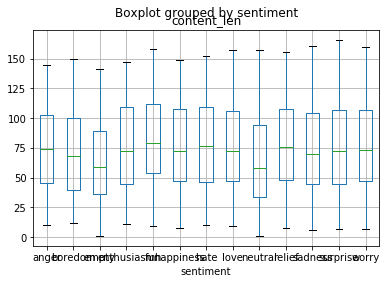

In [142]:
# Create a boxplot showing the sentiment versus the content_len and see if there is any noticable
# relationship between content length and the emotion
# box plot of number ingredients for each cuisine
raw_data.boxplot('content_len', by='sentiment')

In [143]:
def liu_hu_lexicon(sentence, verbose=False):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.

    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    :return array of integers: 1 = positive, 0 = neutral, -1 = negative
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) # negative
        else:
            y.append(0) # neutral

    y_sum = sum(y) 
    if y_sum > 0:
        disposition = 1
    elif y_sum < 0:
        disposition = -1
    else:
        disposition = 0
    
    if verbose:
        if disposition == 1:
            print('Positive: {}'.format(sentence))
        elif disposition == -1:
            print('Negative: {}'.format(sentence))
        else:
            print('Neutral: {}'.format(sentence))

    return disposition


In [144]:
# THIS TAKES A VERY VERY LONG TIME
#liu_hu_lexicon_series = training_data.content.apply(liu_hu_lexicon)

In [145]:
grouped = raw_data.groupby('sentiment')
print(grouped['number_of_exclamations'].agg(np.mean))

sentiment
anger         0.724490
boredom       0.350318
empty         0.270106
enthusiasm    0.693487
fun           0.718750
happiness     0.807100
hate          0.619208
love          0.658607
neutral       0.285804
relief        0.491675
sadness       0.411350
surprise      0.542467
worry         0.408180
Name: number_of_exclamations, dtype: float64


In [146]:
grouped = raw_data.groupby('sentiment')
print(grouped['number_of_mentions'].agg(np.mean))

sentiment
anger         0.438776
boredom       0.254777
empty         0.493171
enthusiasm    0.507663
fun           0.607537
happiness     0.531815
hate          0.364785
love          0.575435
neutral       0.547003
relief        0.460333
sadness       0.415079
surprise      0.539988
worry         0.439796
Name: number_of_mentions, dtype: float64


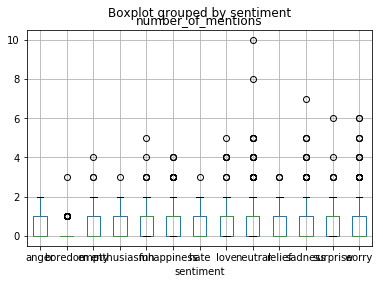

In [147]:
raw_data.boxplot('number_of_mentions', by='sentiment')

## Write out the new Training DataFrame with the new feature columns.

This training data set will be used as the input when working through the model.

In [150]:
# write out the new dataframe

raw_data.to_csv('../data/kaggle/sa-emotions/train_data_with_features.csv')

In [151]:
raw_data.shape

(30000, 9)

# Ready for final Modeling

We now have a training data set with the original content PLUS additional feature columns.

Now we can read in the training data, and create the necessary preprocessing pipelines and feature unions to run the model.

In [191]:
class SentimentNumberTransformer(TransformerMixin):

    def __init__(self, unique_labels):
        # encode the sentiment outcomes as a number using the LabelEncoder
        # would like to create a column, e.g. sentiment_num, which is a numeric representation of the sentiment.
        # this will have to also be applied to any test data.
        self.label_encoder = LabelEncoder()

        # fit the label encoder with the unique set of sentiments in the training data.
        self.label_encoder.fit(unique_labels)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """

        :param X: DataFrame
        :return:
        """
        X['sentiment_num'] = X.sentiment.apply(lambda x: self.label_encoder.transform([x])[0])
        


In [242]:
# read in the training data
training_data = pd.read_csv('../data/kaggle/sa-emotions/train_data.csv')
training_data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,sadness,Layin n bed with a headache ughhhh...waitin on your call...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."


In [243]:
"""
Read the data, setup the function transformers, add the features to the training data.
"""

# -----------------  Function Transformers ----------------
def get_features_df(df):
    return df.loc[:, ['number_of_mentions', 'number_of_ellipsis', 'number_of_exclamations', 'number_of_hashtabs', 'number_of_question', 'is_boredom', 'content_len']]

def get_sentiment_content(df):
    return df.content.copy()

def get_sentiment_content_negation(df):
    return df.content_negation.copy()

def get_sentiment_content_preprocess_negation(df):
    return df.content_preprocessed_negation


# create a function transformer to just extract the feature columns
get_features_transformer = FunctionTransformer(get_features_df, validate=False)
# usage: get_features_transformer.transform(training_data_with_features).head()

# create a function transformer to return the sentiment content so it can be used in pipeline/union
get_sentiment_content_transformer = FunctionTransformer(get_sentiment_content, validate=False)

get_sentiment_content_negation_transformer = FunctionTransformer(get_sentiment_content_negation, validate=False)

get_sentiment_content_preprocess_negation_transformer = FunctionTransformer(get_sentiment_content_preprocess_negation, validate=False)

# -----------------  End Function Transformers ----------------

def preprocess_data_set(input_data_set):


    # encode the sentiment outcomes as a number using the LabelEncoder
    # would like to create a column, e.g. sentiment_num, which is a numeric representation of the sentiment.
    # this will have to also be applied to any test data.
    label_encoder = LabelEncoder()
    # fit the label encoder with the unique set of sentiments in the training data.
    label_encoder.fit(input_data_set.sentiment.unique())
    # print out what classes were discovered
    #print(list(label_encoder.classes_))
    # add the sentiment_num column
    input_data_set['sentiment_num'] = input_data_set.sentiment.apply(lambda x: label_encoder.transform([x])[0])

    # Create a pipeline with the transformers we are keeping, and see the overall improvement.
    preprocessor_pipeline = make_pipeline(get_sentiment_content_transformer, RemoveNumbersTransformer(), RemoveUsernameTransformer())
    preprocessed_training_data_content = preprocessor_pipeline.transform(input_data_set)
    input_data_set['content_preprocessed'] = preprocessed_training_data_content
    input_data_set['content_preprocessed_negation'] = input_data_set.content_preprocessed.apply(mark_negation_sentence)

    make_features(input_data_set)

    #training_data.head()


In [244]:
preprocess_data_set(training_data)

In [245]:
training_data.head()

,sentiment,content,sentiment_num,content_preprocessed,content_preprocessed_negation,number_of_mentions,number_of_ellipsis,number_of_exclamations,number_of_hashtabs,number_of_question,is_boredom,content_len
0,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,2,i know i was listenin to bad habit earlier and i started freakin at his part =[,i know i was listenin to bad habit earlier and i started freakin at his part =[,1,0,0,0,0,0,92
1,sadness,Layin n bed with a headache ughhhh...waitin on your call...,10,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...,0,2,0,0,0,0,60
2,sadness,Funeral ceremony...gloomy friday...,10,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,0,2,0,0,0,0,35
3,enthusiasm,wants to hang out with friends SOON!,3,wants to hang out with friends SOON!,wants to hang out with friends SOON!,0,0,1,0,0,0,36
4,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",8,"We want to trade with someone who has Houston tickets, but no one will.","We want to trade with someone who has Houston tickets, but no one_NEG will._NEG",1,0,0,0,0,0,86


In [248]:

# create stemmer and vectorizer
stemmer = nltk.stem.SnowballStemmer('english')
stemmed_tfidf_vectorizer = StemmedTfidfVectorizer(stemmer=stemmer, min_df=5, max_df=0.8, ngram_range=(1,4), stop_words='english', sublinear_tf=True)


union = make_union(make_pipeline(get_sentiment_content_preprocess_negation_transformer, stemmed_tfidf_vectorizer),
                  get_features_transformer)

# check to the resulting document term matrix
#X_dtm = union.fit_transform(training_data)
#X_dtm.shape


y = training_data.sentiment_num


# create LogisticRegression Model
# 0.3250
model = LogisticRegression(C=0.1)

# 0.307
#model = MultinomialNB()

model_pipeline = make_pipeline(union, model)
cross_val_score(model_pipeline, training_data, y, cv=5, scoring='accuracy').mean()



0.32503805215779058